In [101]:
# Cell 0 — Imports & config
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To make plots readable in notebooks
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

DATA_PATH = "/Volumes/Suvayan/Study/Resume/Professional Project/Netflix_Content_project/data/netflix_titles.csv"

# Output folders
PROJECT_ROOT = Path(".").resolve()
REPORTS_DIR = PROJECT_ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
TABLE_DIR = REPORTS_DIR / "tables"

for p in [FIG_DIR, TABLE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{name}.png", dpi=150)
    plt.show()

def save_table(df: pd.DataFrame, name: str):
    df.to_csv(TABLE_DIR / f"{name}.csv", index=False)


In [102]:
# Cell 1 — Load data
df_raw = pd.read_csv(DATA_PATH)
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

print("Rows, Columns:", df_raw.shape)
df_raw.head(3)


Rows, Columns: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [103]:
# Cell 2 — Cleaning
df = df_raw.copy()

# Fill NAs
text_cols = ["title","director","cast","country","listed_in","description","rating","duration","type"]
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].fillna("").astype(str).str.strip().str.replace(r"\s+", " ", regex=True)

# Parse dates and numerics
if "date_added" in df.columns:
    df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
if "release_year" in df.columns:
    df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
 
# replace empty with 'Unrated'
if "rating" in df.columns:
    df["rating"] = df["rating"].replace("", "Unrated")

# Normalize type casing
if "type" in df.columns:
    df["type"] = df["type"].str.title().replace({"Tv Show": "TV Show"})

# Remove duplicates
df = df.drop_duplicates()
if "show_id" in df.columns:
    df = df.drop_duplicates(subset=["show_id"], keep="last")

print("After cleaning:", df.shape)
df.head(3)


After cleaning: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [104]:
# Cell 3 — Feature engineering
import re

def duration_to_minutes(s: str) -> float:

    if not isinstance(s, str) or s == "":
        return np.nan
    s = s.lower().strip()
    m = re.match(r"(\d+)\s*min", s)
    if m:
        return float(m.group(1))
    m = re.match(r"(\d+)\s*season", s)
    if m:
        seasons = float(m.group(1))
        return seasons * 8 * 45  
    return np.nan

# Duration in minutes
if "duration" in df.columns:
    df["duration_minutes"] = df["duration"].apply(duration_to_minutes)

# Adding Year & month
if "date_added" in df.columns:
    df["year_added"] = df["date_added"].dt.year
    df["month_added"] = df["date_added"].dt.month

# Time Taken to reach platform
if "release_year" in df.columns and "date_added" in df.columns:
    df["time_to_platform_years"] = df["date_added"].dt.year - df["release_year"]

# Convert strings to lists
def split_list(s):
    return [t.strip() for t in s.split(",")] if isinstance(s, str) and s else []

for col in ["listed_in","country","cast","director"]:
    if col in df.columns:
        df[col] = df[col].apply(split_list)
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_minutes,year_added,month_added,time_to_platform_years
0,s1,Movie,Dick Johnson Is Dead,[Kirsten Johnson],[],[United States],2021-09-25,2020,PG-13,90 min,[Documentaries],"As her father nears the end of his life, filmm...",90.0,2021.0,9.0,1.0
1,s2,TV Show,Blood & Water,[],"[Ama Qamata, Khosi Ngema, Gail Mabalane, Thaba...",[South Africa],2021-09-24,2021,TV-MA,2 Seasons,"[International TV Shows, TV Dramas, TV Mysteries]","After crossing paths at a party, a Cape Town t...",720.0,2021.0,9.0,0.0
2,s3,TV Show,Ganglands,[Julien Leclercq],"[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nab...",[],2021-09-24,2021,TV-MA,1 Season,"[Crime TV Shows, International TV Shows, TV Ac...",To protect his family from a powerful drug lor...,360.0,2021.0,9.0,0.0


In [105]:
# Cell 4 — Data health scan
missing_pct = df.isna().mean().sort_values(ascending=False).reset_index()
missing_pct.columns = ["column", "missing_ratio"]
missing_pct.head(10)

,column,missing_ratio
0,date_added,0.011128
1,year_added,0.011128
2,month_added,0.011128
3,time_to_platform_years,0.011128
4,duration_minutes,0.000341
5,show_id,0.000000
6,type,0.000000
7,title,0.000000
8,director,0.000000
9,cast,0.000000


In [106]:

# Cell 4b — Row counts by type (Movie vs TV Show)
type_counts = df.groupby("type").size().reset_index(name="count").sort_values("count", ascending=False)
type_counts


,type,count
0,Movie,6131
1,TV Show,2676


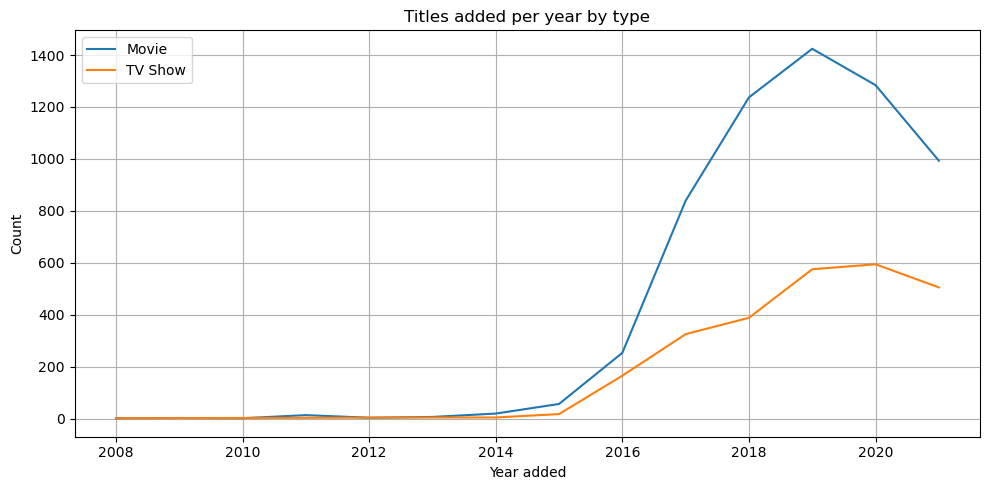

,year_added,type,count
14,2017.0,Movie,839
15,2017.0,TV Show,325
16,2018.0,Movie,1237
17,2018.0,TV Show,388
18,2019.0,Movie,1424
19,2019.0,TV Show,575
20,2020.0,Movie,1284
21,2020.0,TV Show,594
22,2021.0,Movie,993
23,2021.0,TV Show,505


In [107]:
# Cell 5 — Trends over time
trend = (df.dropna(subset=["year_added"])
           .groupby(["year_added","type"])
           .size().reset_index(name="count")
           .sort_values(["year_added","type"]))

plt.figure()
for t, dsub in trend.groupby("type"):
    dsub = dsub.sort_values("year_added")
    plt.plot(dsub["year_added"], dsub["count"], label=t)
plt.title("Titles added per year by type")
plt.xlabel("Year added")
plt.ylabel("Count")
plt.legend()
savefig("trend_titles_by_type")

trend.tail(10)


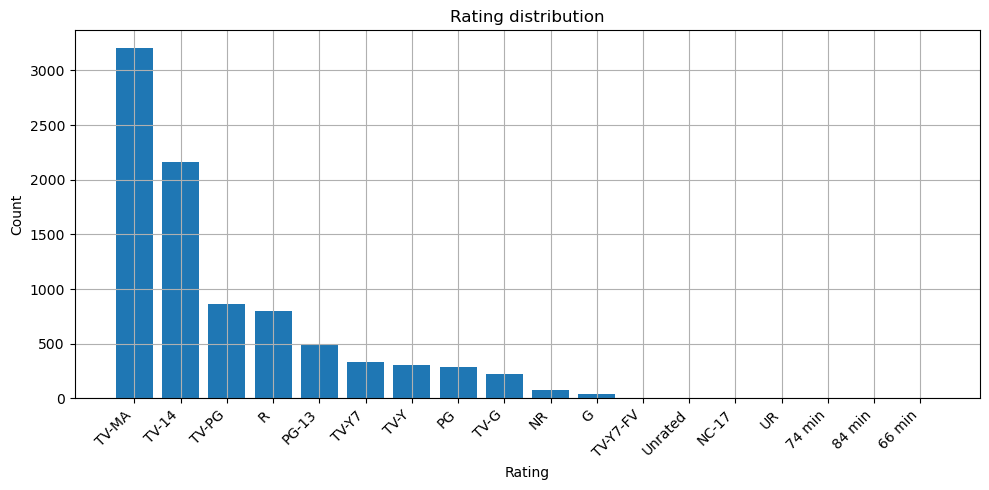

,rating,count
11,TV-MA,3207
9,TV-14,2160
12,TV-PG,863
8,R,799
7,PG-13,490
14,TV-Y7,334
13,TV-Y,307
6,PG,287
10,TV-G,220
5,NR,80


In [108]:
# Cell 6 — Rating distribution
rating_dist = (df.assign(rating=lambda d: d["rating"].replace("", "Unrated"))
                 .groupby("rating").size().reset_index(name="count")
                 .sort_values("count", ascending=False))

plt.figure()
plt.bar(rating_dist["rating"].astype(str), rating_dist["count"])
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
savefig("rating_distribution")

save_table(rating_dist, "rating_distribution")
rating_dist.head(15)


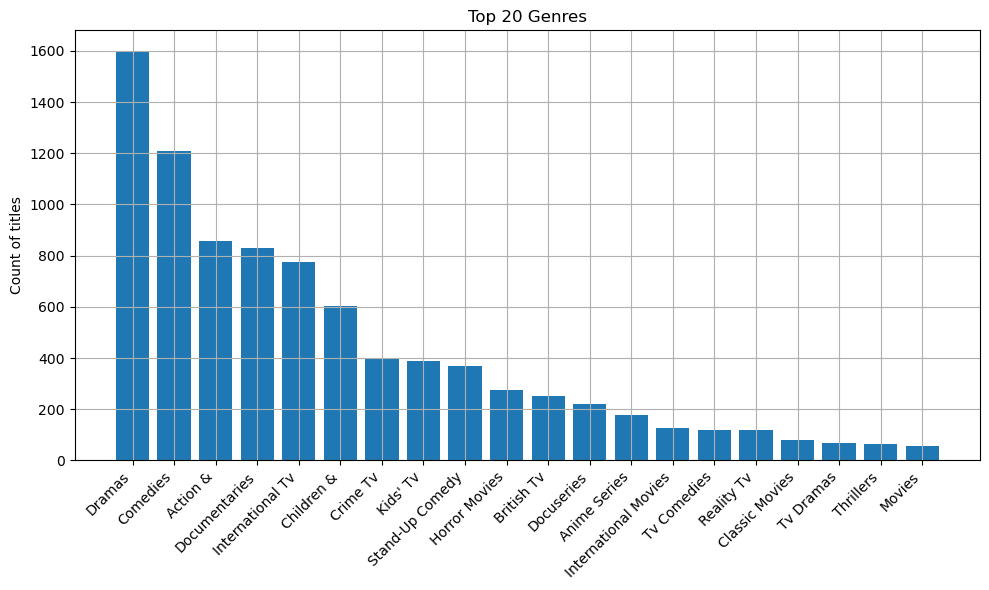

,genre,count
0,Dramas,1600
1,Comedies,1210
2,Action &,859
3,Documentaries,829
4,International Tv,774
5,Children &,605
6,Crime Tv,399
7,Kids' Tv,388
8,Stand-Up Comedy,368
9,Horror Movies,275


In [109]:
# Cell 7 — Clean Genre and Plot Top Genres

def first_genre(val) -> str:
    if isinstance(val, list) and len(val) > 0:
        label = val[0]
    elif isinstance(val, str) and val.strip():
        label = val.split(",")[0]
    else:
        return ""
    return " ".join(label.strip().split()[:2]).title()

# Build the genre coloumn
df["genre"] = df["listed_in"].apply(first_genre)

# Plot
genre_counts = (df.loc[df["genre"] != "", "genre"]
                  .value_counts()
                  .reset_index(name="count")
                  .rename(columns={"index": "genre"}))

top_g = genre_counts.head(20)

plt.figure(figsize=(10, 6))
plt.bar(top_g["genre"], top_g["count"])
plt.title("Top 20 Genres")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count of titles")
plt.tight_layout()
plt.show()

top_g.head(10) 


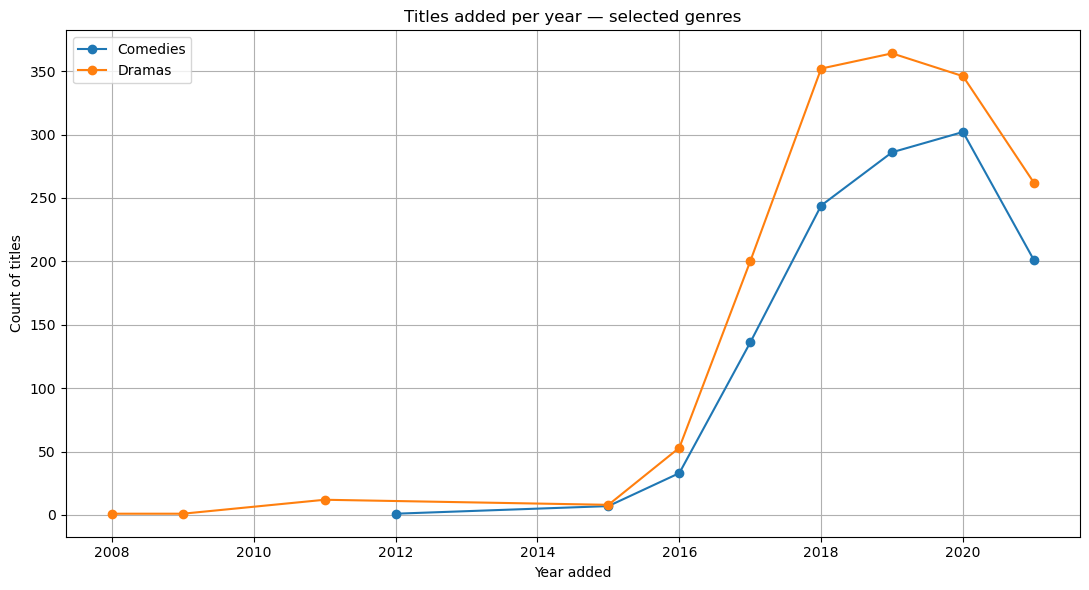

In [110]:
# Cell 7b: To select some genres and plot their trends over time
focus_genres = ["Dramas", "Comedies"] 

if "year_added" not in df.columns:
    df["year_added"] = pd.to_datetime(df["date_added"], errors="coerce").dt.year

# Prepare yearly counts
use = df.loc[(df["genre"] != "") & df["year_added"].notna(), ["genre","year_added","title"]].copy()
yearly = (use.groupby(["year_added","genre"])
              .agg(count=("title","nunique"))
              .reset_index())

yearly_focus = yearly[yearly["genre"].isin(focus_genres)]

# Plot
plt.figure(figsize=(11,6))
for g, d in yearly_focus.groupby("genre"):
    d = d.sort_values("year_added")
    plt.plot(d["year_added"], d["count"], marker="o", label=g)

plt.title("Titles added per year — selected genres")
plt.xlabel("Year added")
plt.ylabel("Count of titles")
plt.legend()
plt.tight_layout()
plt.show()


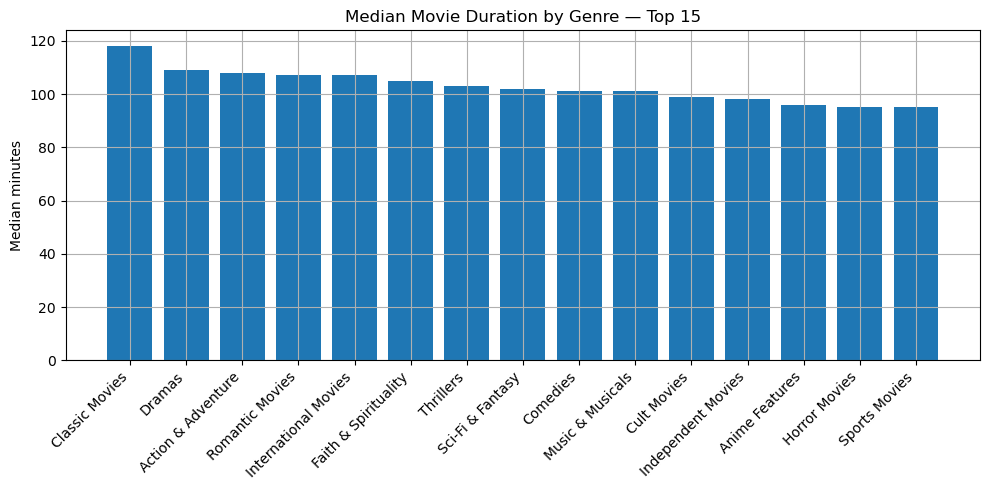

,listed_in,duration_minutes
3,Classic Movies,118.0
7,Dramas,109.0
0,Action & Adventure,108.0
15,Romantic Movies,107.0
11,International Movies,107.0
8,Faith & Spirituality,105.0
19,Thrillers,103.0
16,Sci-Fi & Fantasy,102.0
4,Comedies,101.0
14,Music & Musicals,101.0


In [111]:
# Cell 8 — Median duration by genre (movies only)

def explode(df, col):
    """Explode a DataFrame list column into long format."""
    return df.explode(col).reset_index(drop=True)

movies = df[df["type"] == "Movie"].copy()

# Ensuring 'duration_minutes' exists in movies
if "duration_minutes" not in movies.columns:
    movies["duration_minutes"] = movies["duration"].apply(duration_to_minutes)

g_duration = (
    explode(movies[["title", "listed_in", "duration_minutes"]], "listed_in")
    .dropna(subset=["duration_minutes"])
    .groupby("listed_in")["duration_minutes"].median()
    .reset_index()
    .sort_values("duration_minutes", ascending=False)
)

top15_dur = g_duration.head(15)
plt.figure()
plt.bar(top15_dur["listed_in"], top15_dur["duration_minutes"])
plt.title("Median Movie Duration by Genre — Top 15")
plt.ylabel("Median minutes")
plt.xticks(rotation=45, ha="right")
savefig("median_duration_by_genre_movies")

save_table(g_duration, "median_duration_by_genre_movies")
g_duration.head(10)


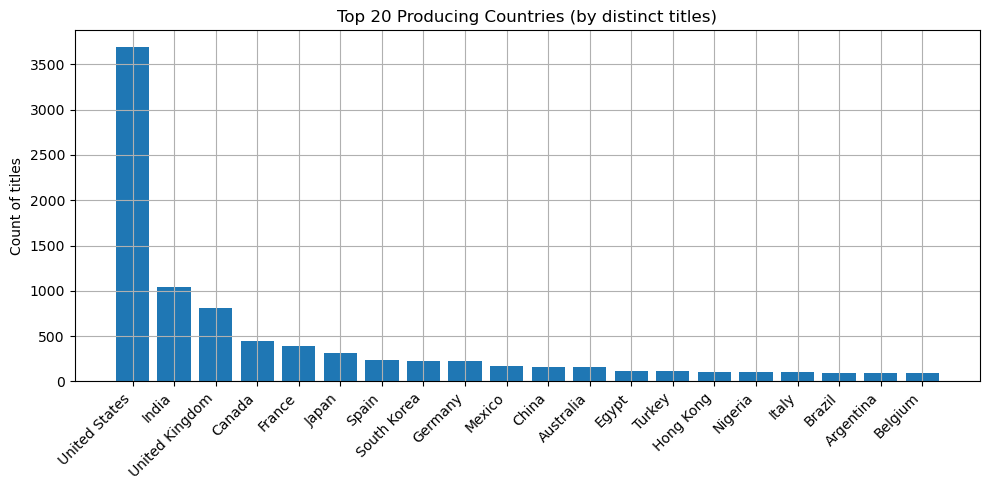

,country,count
116,United States,3690
46,India,1046
115,United Kingdom,806
21,Canada,445
37,France,393
54,Japan,318
103,Spain,232
101,South Korea,231
39,Germany,226
68,Mexico,169


In [112]:
# Cell 9 — Top production countries
countries_long = explode(df[["title","country"]], "country")
top_countries = (countries_long.groupby("country")["title"]
                 .nunique().reset_index(name="count")
                 .sort_values("count", ascending=False))

top20_countries = top_countries.head(20)

plt.figure()
plt.bar(top20_countries["country"], top20_countries["count"])
plt.title("Top 20 Producing Countries (by distinct titles)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count of titles")
savefig("top20_countries")

save_table(top_countries, "top_producing_countries")
top_countries.head(10)


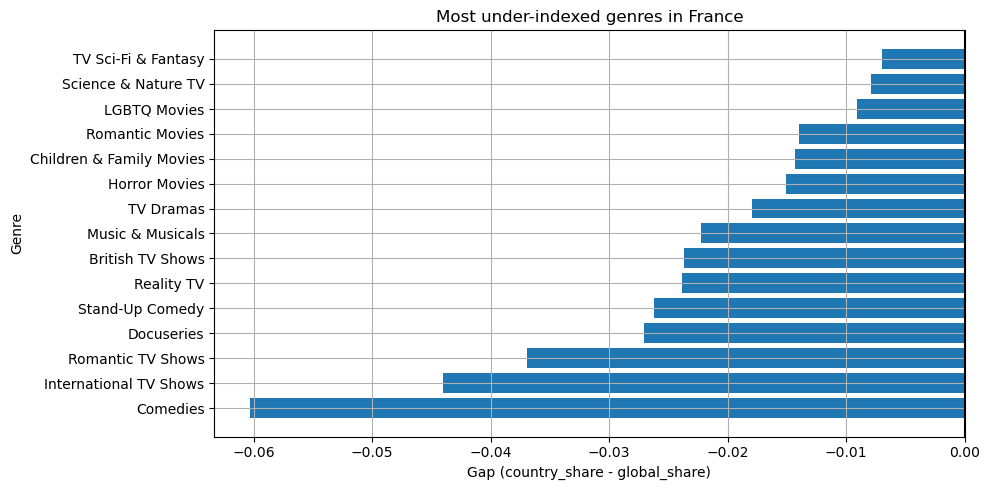

,country,listed_in,cnt,country_total,genre_total,country_share,global_share,gap,country_total_y
382,France,Comedies,51,393,1674,0.129771,0.190098,-0.060327,393
392,France,International TV Shows,43,393,1351,0.109415,0.153418,-0.044003,393
399,France,Romantic TV Shows,2,393,370,0.005089,0.042017,-0.036928,393
386,France,Docuseries,7,393,395,0.017812,0.044856,-0.027044,393
403,France,Stand-Up Comedy,5,393,343,0.012723,0.038951,-0.026228,393
397,France,Reality TV,2,393,255,0.005089,0.028958,-0.023868,393
379,France,British TV Shows,2,393,253,0.005089,0.028730,-0.023641,393
396,France,Music & Musicals,8,393,375,0.020356,0.042585,-0.022228,393
407,France,TV Dramas,27,393,763,0.068702,0.086645,-0.017943,393
389,France,Horror Movies,10,393,357,0.025445,0.040541,-0.015095,393


In [113]:
# Cell 9b — Country–genre content gaps
# Measuring a "gap" = country_share(genre) - global_share(genre).
# Negative = under-indexed in that country (potential acquisition opportunity).

cg = (countries_long.merge(explode(df[["title","listed_in"]], "listed_in"),
                           on="title", how="inner"))

country_tot = cg.groupby("country")["title"].nunique().rename("country_total")
genre_tot   = cg.groupby("listed_in")["title"].nunique().rename("genre_total")
global_total = cg["title"].nunique()

cgm = (cg.groupby(["country","listed_in"])["title"].nunique()
         .rename("cnt").reset_index())
cgm = (cgm.merge(country_tot, on="country")
          .merge(genre_tot, on="listed_in"))

cgm["country_share"] = cgm["cnt"] / cgm["country_total"]
cgm["global_share"]  = cgm["genre_total"] / global_total
cgm["gap"] = cgm["country_share"] - cgm["global_share"]

# Filter to countries with enough titles
MIN_TITLES = 30
cgm_valid = (cgm.merge(country_tot, on="country")
               .query("country_total_x >= @MIN_TITLES")
               .rename(columns={"country_total_x":"country_total"}))

save_table(cgm_valid.sort_values("gap"), "country_genre_gaps_full")

# Focus view for a specific country
COUNTRY_FOCUS = "France" 

country_view = (cgm_valid[cgm_valid["country"] == COUNTRY_FOCUS]
                .sort_values("gap"))

# Plot bottom 15 (most under-indexed)
bottom15 = country_view.head(15)
plt.figure()
plt.barh(bottom15["listed_in"], bottom15["gap"])
plt.title(f"Most under-indexed genres in {COUNTRY_FOCUS}")
plt.xlabel("Gap (country_share - global_share)")
plt.ylabel("Genre")
plt.axvline(0, color="black")
savefig(f"content_gaps_{COUNTRY_FOCUS.lower().replace(' ','_')}")

country_view.head(15)


In [114]:
# Cell 10

median_ttp = df["time_to_platform_years"].median(skipna=True)

snapshot = {
    "Total titles": df["title"].nunique(),
    "Movies": int((df["type"] == "Movie").sum()),
    "TV Shows": int((df["type"] == "TV Show").sum()),
    "Distinct genres": explode(df[["title","listed_in"]], "listed_in")["listed_in"].nunique(),
    "Distinct countries": countries_long["country"].nunique(),
    "Median time-to-platform (yrs)": None if pd.isna(median_ttp) else int(round(median_ttp))
}

snap_df = (
    pd.DataFrame.from_dict(snapshot, orient="index", columns=["value"])
      .astype({"value": "Int64"})
)
snap_df


,value
Total titles,8806
Movies,6131
TV Shows,2676
Distinct genres,42
Distinct countries,123
Median time-to-platform (yrs),1
